![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/PySpark/5.PySpark_Regression.ipynb)


# **PySpark Tutorial-5 Regression**


## **Overview**

In this notebook, linear regression is performed for the Advertising dataset using PySpark.


## **LINEAR REGRESSION**

[spark](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression)


To establish the possible relationship among different variables, various modes of statistical approaches are implemented, known as regression analysis. In order to understand how the variation in an independent variable can impact the dependent variable, regression analysis is specially moulded out. Basically;

- Regression analysis sets up an equation to explain the significant relationship between one or more predictors and response variables and also to estimate current observations.

- The regression outcomes lead to the identification of the direction, size, and analytical significance of the relationship between predictor and response where the dependent variable could be numerical or discrete in nature.


It is the simplest regression technique used for predictive analysis, a linear approach for featuring the relationship between the response and predictors or descriptive variables. It mainly considers the conditional probability distribution of the response presents the predictor’s uses.

**Y = bX+C**, where Y is a dependent variable and X, is the independent variable, that shows a best fitted straight line(regression curve) having b as the slope of the line and C intercept.

[link text](https://www.analyticssteps.com/blogs/7-types-regression-technique-you-should-know-machine-learning)


### **Install spark**


In [ ]:
%pip install -q pyspark==3.5.6

Note: you may need to restart the kernel to use updated packages.


### **Import Library**


In [1]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName("linear").getOrCreate()  ## start spark session

spark

### **Read Data and EDA**


In [6]:
# Run these lines to fetch the sample dataset if you are on Colab
!mkdir -p ./data
!wget -q -P ./data https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/PySpark/data/Advertising.csv

In [7]:
adv = spark.read.csv("./data/Advertising.csv", inferSchema=True, header=True)
## read csv file

## header – uses the first line as names of columns. If None is set, it uses the default value, false.
## inferSchema – infers the input schema automatically from data. It requires one extra pass over the data. If None is set, it uses the default value, false.

**_Header:_** If the csv file have a header (column names in the first row) then set header=true. This will use the first row in the csv file as the dataframe's column names. Setting header=false (default option) will result in a dataframe with default column names: \_c0, \_c1, \_c2, etc. Setting this to true or false should be based on your input file.

**_Schema:_** The schema refered to here are the column types. A column can be of type String, Double, Long, etc. Using inferSchema=false (default option) will give a dataframe where all columns are strings (StringType). Depending on what you want to do, strings may not work. For example, if you want to add numbers from different columns, then those columns should be of some numeric type (strings won't work).
By setting inferSchema=true, Spark will automatically go through the csv file and infer the schema of each column. This requires an extra pass over the file which will result in reading a file with inferSchema set to true being slower. But in return the dataframe will most likely have a correct schema given its input. [link text](https://stackoverflow.com/questions/56927329/spark-option-inferschema-vs-header-true/56933052#:~:text=By%20setting%20inferSchema%3Dtrue%20%2C%20Spark,correct%20schema%20given%20its%20input.)


In [8]:
adv.printSchema()  # getting information about all column from dataset

# Prints out the schema in the tree format.

root
 |-- TV: double (nullable = true)
 |-- radio: double (nullable = true)
 |-- newspaper: double (nullable = true)
 |-- sales: double (nullable = true)



In [9]:
adv.head(5)  # getting first five rows from dataset

[Row(TV=230.1, radio=37.8, newspaper=69.2, sales=22.1),
 Row(TV=44.5, radio=39.3, newspaper=45.1, sales=10.4),
 Row(TV=17.2, radio=45.9, newspaper=69.3, sales=9.3),
 Row(TV=151.5, radio=41.3, newspaper=58.5, sales=18.5),
 Row(TV=180.8, radio=10.8, newspaper=58.4, sales=12.9)]

In [10]:
adv.show()  # getting first 20 rows from dataset ---- default 20

+-----+-----+---------+-----+
|   TV|radio|newspaper|sales|
+-----+-----+---------+-----+
|230.1| 37.8|     69.2| 22.1|
| 44.5| 39.3|     45.1| 10.4|
| 17.2| 45.9|     69.3|  9.3|
|151.5| 41.3|     58.5| 18.5|
|180.8| 10.8|     58.4| 12.9|
|  8.7| 48.9|     75.0|  7.2|
| 57.5| 32.8|     23.5| 11.8|
|120.2| 19.6|     11.6| 13.2|
|  8.6|  2.1|      1.0|  4.8|
|199.8|  2.6|     21.2| 10.6|
| 66.1|  5.8|     24.2|  8.6|
|214.7| 24.0|      4.0| 17.4|
| 23.8| 35.1|     65.9|  9.2|
| 97.5|  7.6|      7.2|  9.7|
|204.1| 32.9|     46.0| 19.0|
|195.4| 47.7|     52.9| 22.4|
| 67.8| 36.6|    114.0| 12.5|
|281.4| 39.6|     55.8| 24.4|
| 69.2| 20.5|     18.3| 11.3|
|147.3| 23.9|     19.1| 14.6|
+-----+-----+---------+-----+
only showing top 20 rows



##### **Import ML Libraries**


In [11]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [12]:
adv.columns  ## getting columns name from dataset

['TV', 'radio', 'newspaper', 'sales']

In [13]:
assembler = VectorAssembler(
    inputCols=["TV", "radio", "newspaper"], outputCol="features"
)
## VectorAssembler = A feature transformer that merges multiple columns into a vector column.

In [14]:
output = assembler.transform(adv)

In [15]:
output.show(3)

+-----+-----+---------+-----+-----------------+
|   TV|radio|newspaper|sales|         features|
+-----+-----+---------+-----+-----------------+
|230.1| 37.8|     69.2| 22.1|[230.1,37.8,69.2]|
| 44.5| 39.3|     45.1| 10.4| [44.5,39.3,45.1]|
| 17.2| 45.9|     69.3|  9.3| [17.2,45.9,69.3]|
+-----+-----+---------+-----+-----------------+
only showing top 3 rows



In [16]:
final_data = output.select("features", "sales")

In [17]:
final_data.show()

+-----------------+-----+
|         features|sales|
+-----------------+-----+
|[230.1,37.8,69.2]| 22.1|
| [44.5,39.3,45.1]| 10.4|
| [17.2,45.9,69.3]|  9.3|
|[151.5,41.3,58.5]| 18.5|
|[180.8,10.8,58.4]| 12.9|
|  [8.7,48.9,75.0]|  7.2|
| [57.5,32.8,23.5]| 11.8|
|[120.2,19.6,11.6]| 13.2|
|    [8.6,2.1,1.0]|  4.8|
| [199.8,2.6,21.2]| 10.6|
|  [66.1,5.8,24.2]|  8.6|
| [214.7,24.0,4.0]| 17.4|
| [23.8,35.1,65.9]|  9.2|
|   [97.5,7.6,7.2]|  9.7|
|[204.1,32.9,46.0]| 19.0|
|[195.4,47.7,52.9]| 22.4|
|[67.8,36.6,114.0]| 12.5|
|[281.4,39.6,55.8]| 24.4|
| [69.2,20.5,18.3]| 11.3|
|[147.3,23.9,19.1]| 14.6|
+-----------------+-----+
only showing top 20 rows



In [18]:
final_data.describe().show()  # describe: Computes basic statistics for numeric and string columns.

+-------+------------------+
|summary|             sales|
+-------+------------------+
|  count|               200|
|   mean|14.022500000000003|
| stddev| 5.217456565710477|
|    min|               1.6|
|    max|              27.0|
+-------+------------------+



#### **Train Test Split**


In [19]:
train_data1, test_data1 = final_data.randomSplit([0.7, 0.3], seed=42)

## split data to train and test for machine learning

In [20]:
train_data1.describe().show()

+-------+------------------+
|summary|             sales|
+-------+------------------+
|  count|               145|
|   mean|14.590344827586216|
| stddev| 5.350030167852781|
|    min|               1.6|
|    max|              27.0|
+-------+------------------+



In [21]:
test_data1.describe().show()

+-------+------------------+
|summary|             sales|
+-------+------------------+
|  count|                55|
|   mean|12.525454545454544|
| stddev| 4.565255993869599|
|    min|               4.8|
|    max|              23.8|
+-------+------------------+



#### **Linear regression**


In [22]:
from pyspark.ml.regression import LinearRegression
import seaborn as sns

In [23]:
linear_regression = LinearRegression(featuresCol="features", labelCol="sales")

In [24]:
linear_model = linear_regression.fit(train_data1)

In [25]:
coefficients = linear_model.coefficients
print("b0 :", linear_model.intercept)
print("b1:", coefficients[0])
print("b2:", coefficients[1])
print("b3:", coefficients[2])

b0 : 2.7355549218842814
b1: 0.04589551388676478
b2: 0.20094136395660905
b3: -0.0034975353898370077


### **Let's get correlation to numeric features**

Heatmap is a data visualization technique that shows correlation between numeric values.

⚠️ If your dataset is large and may not fit into driver memory, you can use the `sample` method to take a sample of your DataFrame before converting to Pandas for plotting on the driver node.

However, in this case, we can use PySpark's built-in Correlation functions to compute correlations without converting to Pandas, since the resulting correlation matrix would be small enough to fit into driver memory.


<Axes: >

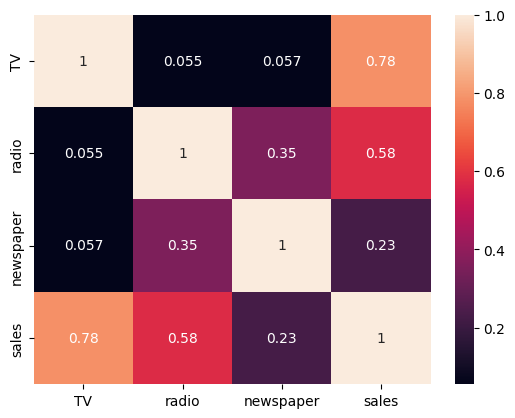

In [26]:
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(
    inputCols=["TV", "radio", "newspaper", "sales"], outputCol="all_columns"
)
vector_df = assembler.transform(output).select("all_columns")

# Compute the correlation matrix
correlation_matrix = (
    Correlation.corr(vector_df, "all_columns").collect()[0][0].toArray()
)
sns.heatmap(
    correlation_matrix,
    annot=True,
    xticklabels=["TV", "radio", "newspaper", "sales"],
    yticklabels=["TV", "radio", "newspaper", "sales"],
)

Getting some visualization and result from prediction and sale values.


In [27]:
predictions = linear_model.transform(test_data1)
predictions.select("prediction", "sales", "features").show(truncate=False)

+------------------+-----+----------------+
|prediction        |sales|features        |
+------------------+-----+----------------+
|8.958660646510953 |5.3  |[5.4,29.9,9.4]  |
|3.5487356702295005|4.8  |[8.6,2.1,1.0]   |
|10.52918016473767 |7.3  |[11.7,36.9,45.2]|
|3.3276257934037163|5.3  |[13.1,0.4,25.6] |
|12.505787163829286|9.3  |[17.2,45.9,69.3]|
|11.036933140805392|8.0  |[17.9,37.6,21.6]|
|5.943349207319566 |6.7  |[18.7,12.1,23.4]|
|10.650422445076002|9.2  |[23.8,35.1,65.9]|
|8.900282091746988 |8.5  |[25.1,25.7,43.3]|
|10.529117271593822|8.8  |[26.8,33.0,19.3]|
|4.246788753531261 |6.9  |[27.5,1.6,20.7] |
|12.535900745893626|10.9 |[38.0,40.3,11.9]|
|5.1839806106183985|7.6  |[38.2,3.7,13.8] |
|12.786832073767068|10.8 |[39.5,41.1,5.8] |
|9.956022495862026 |10.1 |[43.1,26.7,35.1]|
|9.899322353672538 |10.1 |[44.7,25.8,20.6]|
|14.366823297762032|11.6 |[48.3,47.0,8.5] |
|11.883231626488863|11.8 |[57.5,32.8,23.5]|
|6.850067944313709 |8.6  |[66.1,5.8,24.2] |
|8.028269456855169 |9.7  |[66.9,

Seaborn's lmplot is a 2D scatterplot with an optional overlaid regression line. This is useful for comparing numeric variables. Logistic regression for binary classification is also supported with lmplot .


In [28]:
predictions2 = predictions.select("prediction", "sales").toPandas()

In [29]:
predictions2.head()

,prediction,sales
0,8.958661,5.3
1,3.548736,4.8
2,10.529180,7.3
3,3.327626,5.3
4,12.505787,9.3


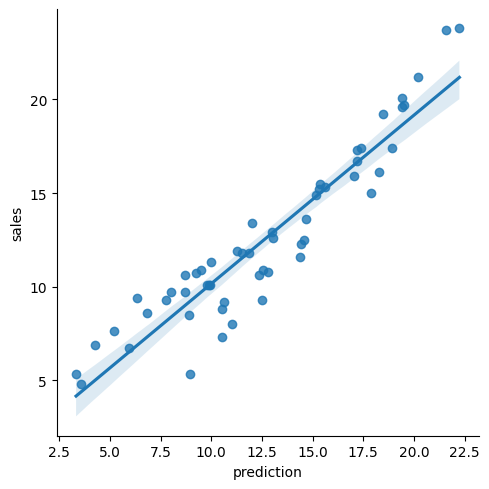

In [30]:
sns.lmplot(x="prediction", y="sales", data=predictions2)

Linear regression is used to study the linear relationship between a dependent variable Y and one or more independent variables X.


In [31]:
from pyspark.ml.evaluation import RegressionEvaluator

In [32]:
metrics = ["r2", "rmse", "mse", "mae"]

for i in metrics:
    pred_evaluator = RegressionEvaluator(
        predictionCol="prediction", labelCol="sales", metricName=i
    )
    print(i, pred_evaluator.evaluate(predictions))

r2 0.865104464823923
rmse 1.6614200921535158
mse 2.760316722611397
mae 1.3365541938281162


**MAE:** The Mean absolute error represents the average of the absolute difference between the actual and predicted values in the dataset. It measures the average of the residuals in the dataset.

**MSE:** Mean Squared Error represents the average of the squared difference between the original and predicted values in the data set. It measures the variance of the residuals.

**RMSE:** Root Mean Squared Error is the square root of Mean Squared error. It measures the standard deviation of residuals.

**R2:** The coefficient of determination or R-squared represents the proportion of the variance in the dependent variable which is explained by the linear regression model. It is a scale-free score i.e. irrespective of the values being small or large, the value of R square will be less than one.

[link text](https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e)
